In [87]:
# Import packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [88]:
# Read Data and convert to local CRS

pharmacies = gpd.read_file("C:/Users/alkaye/geodemographics-demonstrator/processed_data/buffered_pharmacies.geojson").to_crs('2180')
osm_amenities = gpd.read_file("C:/Users/alkaye/geodemographics-demonstrator/processed_data/osm_amenities.geojson").to_crs('2180')
population = gpd.read_file("C:/Users/alkaye/geodemographics-demonstrator/processed_data/population_by_muninciple.geojson").to_crs('2180')

In [89]:
len(pharmacies)

12486

In [104]:
# Get pct of population within pharmacy buffers

# Define column lists
pharmacy_columns = ['name', 'buffer_area', 'Type']

population_columns = ['total', 'total_male',
       'total_female', '0-4_total', '0-4_males', '0-4_females', '5-9_total',
       '5-9_males', '5-9_females', '10-14_total', '10-14_males',
       '10-14_females', '15-19_total', '15-19_males', '15-19_females',
       '20-24_total', '20-24_males', '20-24_females', '25-29_total',
       '25-29_males', '25-29_females', '30-34_total', '30-34_males',
       '30-34_females', '35-39_total', '35-39_males', '35-39_females',
       '40-44_total', '40-44_males', '40-44_females', '45-49_total',
       '45-49_males', '45-49_females', '50-54_total', '50-54_males',
       '50-54_females', '55-59_total', '55-59_males', '55-59_females',
       '60-64_total', '60-64_males', '60-64_females', '65-69_total',
       '65-69_males', '65-69_females', '70-74_total', '70-74_males', '70-74_females',
       '75-79_total', '75-79_males', '75-79_females', '80-84_total',
       '80-84_males', '80-84_females', '85 and more_total', '85_more_males',
       '85_more_females']

# Calculate areas
pharmacies['buffer_area'] = pharmacies.area
population['muninciple_area'] = population.area

# Performing overlay funcion
gdf_joined = gpd.overlay(pharmacies, population, how='union', keep_geom_type=False)
gdf_joined['area_joined'] = gdf_joined.area

# Calculating the pct of munincple area within each pharmacy buffer
gdf_joined['pct_of_muninciple_area'] = (gdf_joined['area_joined'] / gdf_joined['muninciple_area'])

# Use the calculated pct to estimate population within each buffer
for col in population_columns:
    gdf_joined[col] = np.round(gdf_joined[col]*gdf_joined['pct_of_muninciple_area'], 0)

# Groupby pharmcy, sum population columns and take the first row for pharmacy cols
first_dict = {col: 'first' for col in pharmacy_columns}
sum_dict = {col: 'sum' for col in population_columns}
agg_dict = first_dict | sum_dict

gdf_joined = gdf_joined.sort_values('pct_of_muninciple_area').groupby('id_1').agg(agg_dict).reset_index().rename(columns={'id_1': 'id'})

# Add in population density
gdf_joined['population_density'] = (gdf_joined['total']/gdf_joined['buffer_area'])*1000

# Drop Buffer area
# TODO: unless this changes to actual drive time zones
gdf_joined = gdf_joined.drop(columns=['buffer_area'])

# Merge back geometries of pharmacies
gdf_joined = gdf_joined.merge(pharmacies[['id', 'geometry']], on='id', how='left')
gdf_joined = gpd.GeoDataFrame(gdf_joined, crs="EPSG:2180", geometry='geometry')

gdf_joined

,id,name,Type,total,total_male,total_female,0-4_total,0-4_males,0-4_females,5-9_total,...,75-79_males,75-79_females,80-84_total,80-84_males,80-84_females,85 and more_total,85_more_males,85_more_females,population_density,geometry
0,node/10004417480,Cosmedica,rural,47546.0,22655.0,24891.0,1841.0,944.0,899.0,2332.0,...,784.0,1213.0,1155.0,401.0,752.0,1188.0,352.0,832.0,0.606348,"POLYGON ((705137.04 204802.193, 705112.964 204..."
1,node/10005929562,None,rural,113034.0,53657.0,59379.0,5954.0,3092.0,2862.0,6435.0,...,1467.0,2245.0,2207.0,752.0,1455.0,2552.0,746.0,1805.0,1.441508,"POLYGON ((718280.037 244636.228, 718255.961 24..."
2,node/10030064809,Eskulap,rural,24127.0,11374.0,12752.0,916.0,450.0,466.0,1062.0,...,452.0,687.0,533.0,178.0,355.0,436.0,112.0,325.0,0.307689,"POLYGON ((479835.109 481920.929, 479811.033 48..."
3,node/10031744317,Rossmann,Cities with powiat status,138987.0,65545.0,73442.0,5038.0,2568.0,2470.0,5936.0,...,2137.0,3589.0,4460.0,1541.0,2918.0,3828.0,1228.0,2600.0,1.772483,"POLYGON ((505348.153 263288.427, 505324.076 26..."
4,node/10044063207,Słoneczna,rural,65639.0,31973.0,33666.0,2687.0,1403.0,1285.0,3460.0,...,825.0,1236.0,1634.0,595.0,1038.0,1263.0,403.0,860.0,0.837086,"POLYGON ((470802.426 249591.408, 470778.35 249..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12481,node/997618842,Słoneczna,urban-rural,98669.0,46116.0,52551.0,3311.0,1699.0,1614.0,4119.0,...,1728.0,2799.0,2487.0,808.0,1679.0,2716.0,706.0,2009.0,1.258313,"POLYGON ((513357.409 328294.072, 513333.333 32..."
12482,node/9978580188,Punkt Apteczny Pod Modrzewiem,rural,3623.0,1819.0,1803.0,146.0,74.0,73.0,189.0,...,45.0,66.0,76.0,25.0,52.0,96.0,25.0,71.0,0.046204,"POLYGON ((763526.316 310826.147, 763502.24 310..."
12483,node/9979355387,Gemini,rural,38940.0,18575.0,20366.0,1755.0,905.0,849.0,2074.0,...,636.0,1062.0,934.0,322.0,612.0,961.0,277.0,684.0,0.496597,"POLYGON ((392352.996 372821.713, 392328.919 37..."
12484,node/9980435506,Apteka Lawenda,rural,13179.0,6504.0,6675.0,513.0,265.0,246.0,652.0,...,167.0,250.0,293.0,100.0,193.0,293.0,86.0,208.0,0.168070,"POLYGON ((678296.679 206392.146, 678272.602 20..."


<Axes: >

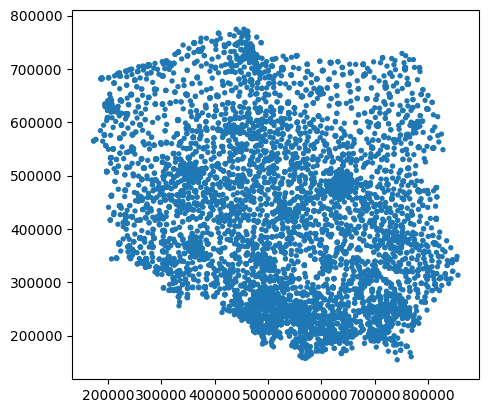

In [105]:
gdf_joined.plot()

In [106]:
# Count ameneties within each buffer

ameneties_within_buffers = osm_amenities.sjoin(pharmacies, predicate='intersects', how='left')
ameneties_within_buffers = ameneties_within_buffers.groupby(['id_right', 'type']).agg({'id_left': 'count'}).reset_index()
ameneties_within_buffers = ameneties_within_buffers.pivot(index='id_right', columns='type', values='id_left').fillna(0).reset_index()
ameneties_within_buffers = ameneties_within_buffers.rename(columns={'id_right': 'id'})
ameneties_within_buffers

type,id,hospital,nursing_home,place_of_worship,school,university
0,node/10004417480,0.0,0.0,12.0,12.0,1.0
1,node/10005929562,1.0,2.0,2.0,92.0,1.0
2,node/10030064809,0.0,0.0,1.0,0.0,0.0
3,node/10031744317,3.0,2.0,13.0,35.0,2.0
4,node/10044063207,0.0,0.0,5.0,13.0,2.0
...,...,...,...,...,...,...
10456,node/9975478922,0.0,0.0,2.0,0.0,0.0
10457,node/997618842,0.0,0.0,9.0,10.0,1.0
10458,node/9979355387,0.0,0.0,0.0,1.0,0.0
10459,node/9980435506,0.0,0.0,1.0,0.0,0.0


In [107]:
# Merge amenties with main gdf

gdf_final = gdf_joined.merge(ameneties_within_buffers, on='id', how='left').fillna(0)
gdf_final

,id,name,Type,total,total_male,total_female,0-4_total,0-4_males,0-4_females,5-9_total,...,85 and more_total,85_more_males,85_more_females,population_density,geometry,hospital,nursing_home,place_of_worship,school,university
0,node/10004417480,Cosmedica,rural,47546.0,22655.0,24891.0,1841.0,944.0,899.0,2332.0,...,1188.0,352.0,832.0,0.606348,"POLYGON ((705137.04 204802.193, 705112.964 204...",0.0,0.0,12.0,12.0,1.0
1,node/10005929562,0,rural,113034.0,53657.0,59379.0,5954.0,3092.0,2862.0,6435.0,...,2552.0,746.0,1805.0,1.441508,"POLYGON ((718280.037 244636.228, 718255.961 24...",1.0,2.0,2.0,92.0,1.0
2,node/10030064809,Eskulap,rural,24127.0,11374.0,12752.0,916.0,450.0,466.0,1062.0,...,436.0,112.0,325.0,0.307689,"POLYGON ((479835.109 481920.929, 479811.033 48...",0.0,0.0,1.0,0.0,0.0
3,node/10031744317,Rossmann,Cities with powiat status,138987.0,65545.0,73442.0,5038.0,2568.0,2470.0,5936.0,...,3828.0,1228.0,2600.0,1.772483,"POLYGON ((505348.153 263288.427, 505324.076 26...",3.0,2.0,13.0,35.0,2.0
4,node/10044063207,Słoneczna,rural,65639.0,31973.0,33666.0,2687.0,1403.0,1285.0,3460.0,...,1263.0,403.0,860.0,0.837086,"POLYGON ((470802.426 249591.408, 470778.35 249...",0.0,0.0,5.0,13.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12481,node/997618842,Słoneczna,urban-rural,98669.0,46116.0,52551.0,3311.0,1699.0,1614.0,4119.0,...,2716.0,706.0,2009.0,1.258313,"POLYGON ((513357.409 328294.072, 513333.333 32...",0.0,0.0,9.0,10.0,1.0
12482,node/9978580188,Punkt Apteczny Pod Modrzewiem,rural,3623.0,1819.0,1803.0,146.0,74.0,73.0,189.0,...,96.0,25.0,71.0,0.046204,"POLYGON ((763526.316 310826.147, 763502.24 310...",0.0,0.0,0.0,0.0,0.0
12483,node/9979355387,Gemini,rural,38940.0,18575.0,20366.0,1755.0,905.0,849.0,2074.0,...,961.0,277.0,684.0,0.496597,"POLYGON ((392352.996 372821.713, 392328.919 37...",0.0,0.0,0.0,1.0,0.0
12484,node/9980435506,Apteka Lawenda,rural,13179.0,6504.0,6675.0,513.0,265.0,246.0,652.0,...,293.0,86.0,208.0,0.168070,"POLYGON ((678296.679 206392.146, 678272.602 20...",0.0,0.0,1.0,0.0,0.0


<Axes: >

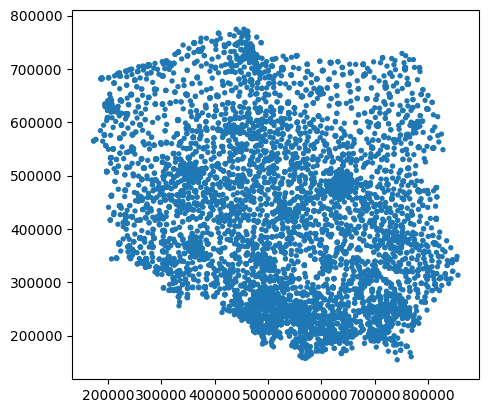

In [109]:
gdf_final.plot()

In [110]:
# Convert to WGS and save
gdf_final = gdf_final.to_crs('4236')
gdf_final.to_file('pharmacies_preprocessed.geojson')